### Libs import

#### Primary libs

In [1]:
from tqdm.notebook import tqdm

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### ML modules

Torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Not Torch

In [4]:
import gc

from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Functions definings

### Dataloading

In [5]:
PATH = 'data/binance/fut/hour'

close = pd.read_csv(f'{PATH}/close.csv', index_col='openTime')
open = pd.read_csv(f'{PATH}/open.csv', index_col='openTime')
high = pd.read_csv(f'{PATH}/high.csv', index_col='openTime')
low = pd.read_csv(f'{PATH}/low.csv', index_col='openTime')
qvolume = pd.read_csv(f'{PATH}/qvolume.csv', index_col='openTime')
bvolume = pd.read_csv(f'{PATH}/bvolume.csv', index_col='openTime')
ntrades = pd.read_csv(f'{PATH}/ntrades.csv', index_col='openTime')
takerbuybvolume = pd.read_csv(f'{PATH}/takerbuybvolume.csv', index_col='openTime')
takerbuyqvolume = pd.read_csv(f'{PATH}/takerbuyqvolume.csv', index_col='openTime')

In [6]:
good_tickers = close.isna().sum()[close.isna().sum() < 10_000].index

close = close[good_tickers]
close.index = pd.to_datetime(close.index)
close = close.resample('4H').first()

open = open[good_tickers]
open.index = pd.to_datetime(open.index)
open = open.resample('4H').first()

high = high[good_tickers]
high.index = pd.to_datetime(high.index)
high = high.resample('4H').first()

low = low[good_tickers]
low.index = pd.to_datetime(low.index)
low = low.resample('4H').first()

bvolume = bvolume[good_tickers]
bvolume.index = pd.to_datetime(bvolume.index)
bvolume = bvolume.resample('4H').first()

qvolume = qvolume[good_tickers]
qvolume.index = pd.to_datetime(qvolume.index)
qvolume = qvolume.resample('4H').first()

ntrades = ntrades[good_tickers]
ntrades.index = pd.to_datetime(ntrades.index)
ntrades = ntrades.resample('4H').first()

takerbuybvolume = takerbuybvolume[good_tickers]
takerbuybvolume.index = pd.to_datetime(takerbuybvolume.index)
takerbuybvolume = takerbuybvolume.resample('4H').first()

takerbuyqvolume = takerbuyqvolume[good_tickers]
takerbuyqvolume.index = pd.to_datetime(takerbuyqvolume.index)
takerbuyqvolume = takerbuyqvolume.resample('4H').first()

In [7]:
returns = close.pct_change().shift(-1).dropna()
ret_col = np.array(returns.columns) + '_ret'
returns.columns = ret_col

close_col = np.array(close.columns) + '_close'
close.columns = close_col

open_col = np.array(open.columns) + '_open'
open.columns = open_col

high_col = np.array(high.columns) + '_high'
high.columns = high_col

low_col = np.array(low.columns) + '_low'
low.columns = low_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

qvolume_col = np.array(qvolume.columns) + '_qvolume'
qvolume.columns = qvolume_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

ntrades_col = np.array(ntrades.columns) + '_ntrades'
ntrades.columns = ntrades_col

takerbuybvolume_col = np.array(takerbuybvolume.columns) + '_takerbuybvolume'
takerbuybvolume.columns = takerbuybvolume_col

takerbuyqvolume_col = np.array(takerbuyqvolume.columns) + '_takerbuyqvolume'
takerbuyqvolume.columns = takerbuyqvolume_col

In [162]:
train_columns = np.array([close_col, open_col, high_col, low_col, bvolume_col, qvolume_col, ntrades_col, takerbuybvolume_col, takerbuyqvolume_col])
train_columns = train_columns.reshape(train_columns.shape[0] * train_columns.shape[1],)

full_data = pd.concat([
  close.pct_change(), open.pct_change(), high.pct_change(), low.pct_change(), bvolume.pct_change(),
  qvolume.pct_change(), ntrades.pct_change(), takerbuybvolume.pct_change(), takerbuyqvolume.pct_change(), returns
], axis=1).dropna()
full_data.index = pd.to_datetime(full_data.index)

training_data = full_data[train_columns]

In [107]:
window_size = 100

all_x = np.lib.stride_tricks.sliding_window_view(training_data.values, (window_size, training_data.shape[1]))[:, 0]
all_y = full_data[ret_col].iloc[99:].values

((7452, 100), (7452,))

In [108]:
# Предполагается, что all_x и all_y уже загружены

# Формируем обучающую выборку
x_test = all_x[-850:].view()  # Все, кроме последних 1000
y_test = all_y[-850:].view()  # Все, кроме последних 1000

x = all_x[:-(850 + 120)].view()
y = all_y[:-(850 + 120)].view()
# del all_x
# del all_y

# Определяем длину валидационной выборки
val_len = 1000

# Определяем индексы для валидационной выборки
val_start = x.shape[0] // 2 - val_len // 2
val_end = val_start + val_len

# Формируем валидационную выборку
x_val = x[val_start:val_end]
y_val = y[val_start:val_end]

# Определяем отступы для тестовой выборки
offset = 110

# Индексы для тестовой выборки
test_start = max(0, val_start - offset)
test_end = min(x.shape[0], val_end + offset)

# Формируем тренировочную выборку
x_train = np.concatenate((x[:test_start], x[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

# Проверяем размеры выборок
print(f"train_x shape: {x_train.shape}")
print(f"train_y shape: {y_train.shape}")
print(f"val_x shape: {x_val.shape}")
print(f"val_y shape: {y_val.shape}")
print(f"test_x shape: {x_test.shape}")
print(f"test_y shape: {y_test.shape}")

train_x shape: (5262, 100)
train_y shape: (5262,)
val_x shape: (1000, 100)
val_y shape: (1000,)
test_x shape: (850, 100)
test_y shape: (850,)


In [109]:
x_train = torch.Tensor(x_train)
x_train = np.where(np.isinf(x_train), np.nan, x_train)
x_train = np.where(np.isnan(x_train), np.nanmean(x_train, axis=0), x_train)
x_train = torch.Tensor(x_train)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = np.where(np.isinf(y_train), np.nan, y_train)
y_train = np.where(np.isnan(y_train), np.nanmean(y_train, axis=0), y_train)
y_train = torch.Tensor(y_train)


x_val = torch.Tensor(x_val)
x_val = np.where(np.isinf(x_val), np.nan, x_val)
x_val = np.where(np.isnan(x_val), np.nanmean(x_val, axis=0), x_val)
x_val = torch.Tensor(x_val)

y_val = torch.tensor(y_val, dtype=torch.float32)
y_val = np.where(np.isinf(y_val), np.nan, y_val)
y_val = np.where(np.isnan(y_val), np.nanmean(y_val, axis=0), y_val)
y_val = torch.Tensor(y_val)

x_test = torch.Tensor(x_test)
x_test = np.where(np.isinf(x_test), np.nan, x_test)
x_test = np.where(np.isnan(x_test), np.nanmean(x_test, axis=0), x_test)
x_test = torch.Tensor(x_test)

y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = np.where(np.isinf(y_test), np.nan, y_test)
y_test = np.where(np.isnan(y_test), np.nanmean(y_test, axis=0), y_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_val.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_test.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

Shape of x_train: torch.Size([5262, 100])
Shape of y_train: torch.Size([5262])
Shape of x_train: torch.Size([1000, 100])
Shape of y_train: torch.Size([850])
Shape of x_train: torch.Size([850, 100])
Shape of y_train: torch.Size([850])


In [157]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 280  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [158]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Определяем LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Определяем полносвязный слой
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Добавление Dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Инициализация скрытого состояния и состояния ячейки
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Пропускаем через LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Берем только последний временной шаг
        out = out[:, -1, :]
        
        # Применение Dropout
        out = self.dropout(out)

        # Пропускаем через полносвязный слой
        out = self.fc(out)
        return out


class SharpeLossPenalty(nn.Module):
    def __init__(self, alpha=0.5, epsilon=1e-8, weight_penalty_factor=0.0001, target_turnover=0.2, k=50.0, turnover_penalty_weight=0.1):
        super(SharpeLossPenalty, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon  # Чтобы избежать деления на 0
        self.weight_penalty_factor = weight_penalty_factor  # Коэффициент штрафа за размер весов
        self.target_turnover = target_turnover  # Целевое значение turnover
        self.k = k  # Коэффициент для экспоненциальной части
        self.turnover_penalty_weight = turnover_penalty_weight  # Вес полиномиальной части штрафа
    
    def turnover_penalty(self, turnover_value):
        """
        Штраф за отклонение turnover от целевого значения.
        Использует экспоненциальную и полиномиальную части для создания гладкой функции штрафа.
        """
        penalty = (1 / 40 * (turnover_value + 0.8 + self.epsilon) ** 5) / 1_300
        return penalty
    
    def forward(self, predictions, targets):
        # Нормализация весов
        weights = predictions - predictions.mean()
        weights = weights.abs().sum() + self.epsilon
        weights = torch.where(weights != 0, predictions / weights, torch.zeros_like(predictions))

        # Вычисление доходности
        weighted_returns = weights * targets
        mean_weighted_return = weighted_returns.sum(axis=1).mean()

        # Вычисление волатильности (дифференцируемая альтернатива std())
        portfolio_returns = weighted_returns.sum(axis=1)
        volatility = torch.sqrt(((portfolio_returns - portfolio_returns.mean()) ** 2).mean() + self.epsilon)

        # Проверка на деление на ноль перед расчетом Sharpe Ratio
        mean_sharpe_ratio = torch.where(volatility != 0, mean_weighted_return / volatility, torch.zeros_like(mean_weighted_return))

        # Штраф за turnover
        predictions_shifted = torch.cat((predictions[1:], predictions.new_zeros((1, predictions.size(1)))), dim=0)
        turnover_value = (predictions - predictions_shifted).abs().sum(dim=1).mean()
        
        # Вычисляем штраф с использованием экспоненциальной и полиномиальной функций
        turnover_penalty = self.turnover_penalty(turnover_value)
        
        share_values.append(mean_weighted_return / (volatility + self.epsilon))
        # weights_penalties.append(weights.abs().max())
        turnover_penalties.append(turnover_penalty)

        # Возврат функции потерь с учетом штрафа
        return -(mean_weighted_return / (volatility + self.epsilon)) # + turnover_penalt

In [159]:
batch_x[0][-1], batch_y[0]

(tensor([0.0068], device='cuda:0'), tensor(-0.0033, device='cuda:0'))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100], Loss: 0.0001365128, Validation Loss: 0.0001335409
Epoch [10/100], Loss: 0.0001036505, Validation Loss: 0.0001262506
Epoch [20/100], Loss: 0.0001041187, Validation Loss: 0.0001273030
Epoch [30/100], Loss: 0.0001043307, Validation Loss: 0.0001278143
Epoch [40/100], Loss: 0.0001043916, Validation Loss: 0.0001279479
Epoch [50/100], Loss: 0.0001043858, Validation Loss: 0.0001279293
Epoch [60/100], Loss: 0.0001043581, Validation Loss: 0.0001278607
Epoch [70/100], Loss: 0.0001043244, Validation Loss: 0.0001277777
Epoch [80/100], Loss: 0.0001042900, Validation Loss: 0.0001276924
Epoch [90/100], Loss: 0.0001042568, Validation Loss: 0.0001276091


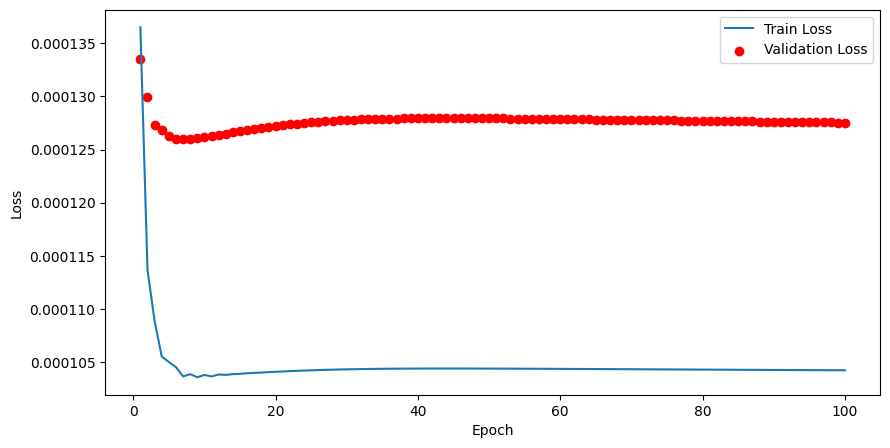

In [160]:
pred_dict = {}
pred_dict['train'] = []
pred_dict['val'] = []
pred_dict['test'] = []

# Гиперпараметры
input_size = 1  # Например, если предсказываем одно значение
hidden_size = 10
output_size = 1  # Предсказываем одно значение
num_layers = 1
num_epochs = 100
learning_rate=0.005
criterion = nn.SmoothL1Loss() .to(device)
PRINT_PARAM = 10

# Инициализация модели, потерь и оптимизатора
model = LSTMModel(
    input_size,
    hidden_size,
    output_size
).to(device)
optimizer = optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

# Листы для хранения значений потерь
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.unsqueeze(-1)
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход (forward pass)
        outputs = model(batch_x)
        
        # Вычисление потерь
        loss = criterion(outputs.squeeze(), batch_y.float())
        
        # Обратный проход (backward pass) для вычисления градиентов
        loss.backward()
        
        # Ограничение градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Обновление весов
        optimizer.step()
        
        # Агрегация потерь за эпоху
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    # Валидация модели
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.unsqueeze(-1)
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            val_loss += criterion(val_outputs.squeeze(), val_y.float()).item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Обновление learning rate через scheduler
    scheduler.step()

    # Печать результатов
    if epoch % PRINT_PARAM == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.10f}, Validation Loss: {val_loss:.10f}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1, 1), train_losses, label='Train Loss')
plt.scatter(range(1, len(val_losses) + 1, 1), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'profit')

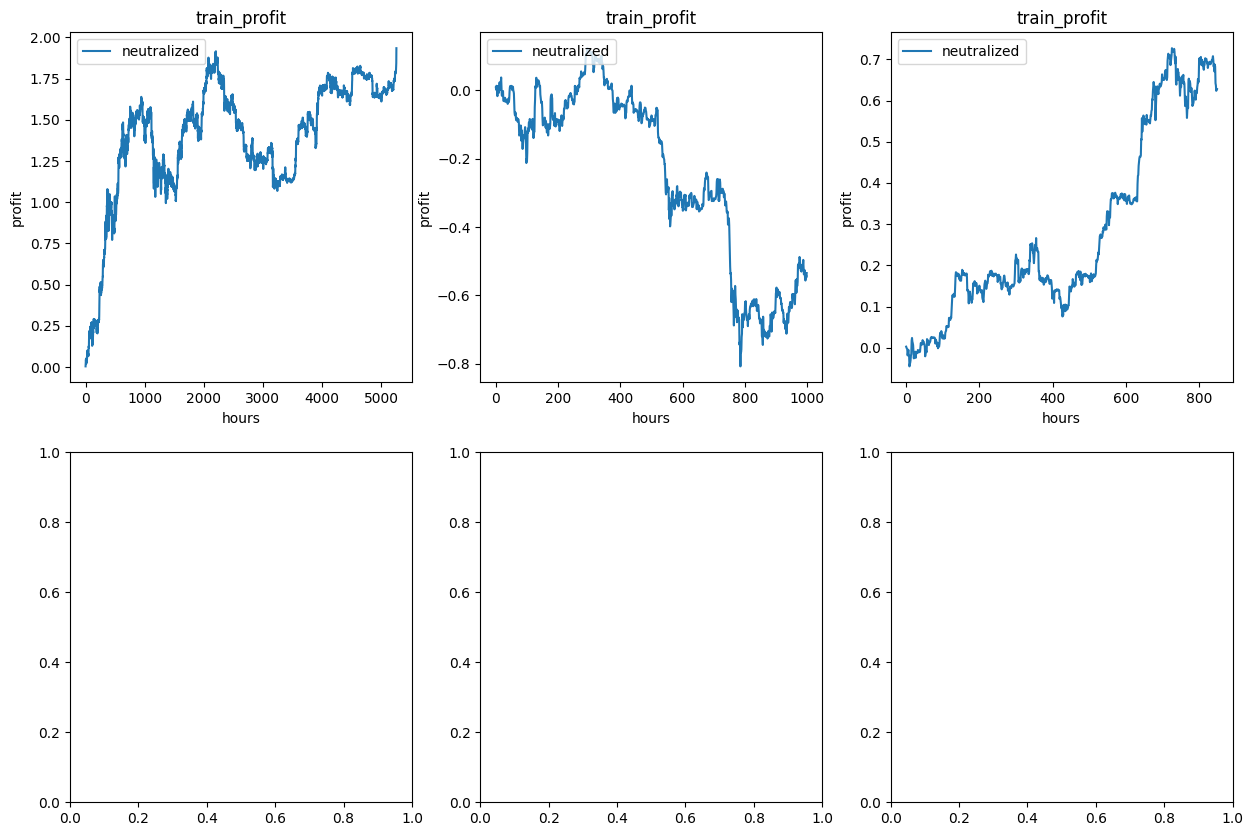

In [161]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

with torch.no_grad():
    train_predictions = model(x_train.unsqueeze(-1).to(device)).detach().cpu().numpy()
    val_predictions = model(x_val.unsqueeze(-1).to(device)).detach().cpu().numpy()
    test_predictions = model(x_test.unsqueeze(-1).to(device)).detach().cpu().numpy()

alpha_train = np.where(train_predictions.reshape(-1) > 0, 1, -1)
alpha_val = np.where(val_predictions.reshape(-1) > 0, 1, -1)
alpha_test = np.where(test_predictions.reshape(-1) > 0, 1, -1)

axes[0, 0].plot(
    (alpha_train * y_train.detach().cpu().numpy().reshape(-1)).cumsum(),
    label='neutralized'
)
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('train_profit')
axes[0, 0].set_xlabel('hours')
axes[0, 0].set_ylabel('profit')

axes[0, 1].plot(
    (alpha_val * y_val.detach().cpu().numpy().reshape(-1)).cumsum(),
    label='neutralized'
)
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('train_profit')
axes[0, 1].set_xlabel('hours')
axes[0, 1].set_ylabel('profit')

axes[0, 2].plot(
    (alpha_test * y_test.detach().cpu().numpy().reshape(-1)).cumsum(),
    label='neutralized'
)
axes[0, 2].legend(loc='upper left')
axes[0, 2].set_title('train_profit')
axes[0, 2].set_xlabel('hours')
axes[0, 2].set_ylabel('profit')

In [154]:
train_predictions.reshape(-1)

array([0.00362702, 0.00362702, 0.00362702, ..., 0.00362702, 0.00362702,
       0.00362702], dtype=float32)

,real,pred
0,0.004503,0.003627
1,0.005001,0.003627
2,-0.001145,0.003627
3,0.018144,0.003627
4,0.009202,0.003627
...,...,...
5257,-0.000877,0.003627
5258,0.017900,0.003627
5259,0.010065,0.003627
5260,0.063244,0.003627


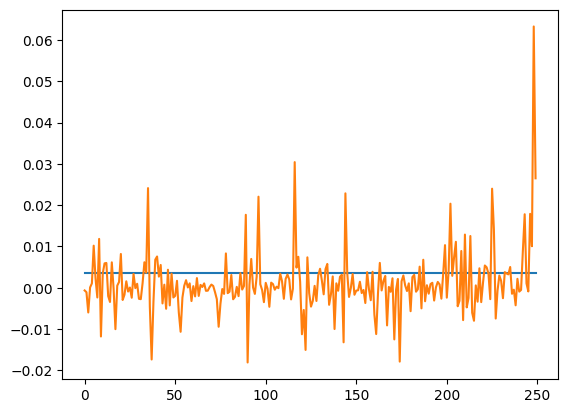

In [156]:
# plt.plot(test_predictions.reshape(-1)[-50:])
# plt.plot(y_test.detach().cpu().numpy().reshape(-1)[-50:])

plt.plot(train_predictions.reshape(-1)[-250:])
plt.plot(y_train.detach().cpu().numpy().reshape(-1)[-250:])

pd.DataFrame({
  'real': y_train.detach().cpu().numpy().reshape(-1),
  'pred': train_predictions.reshape(-1)
})